Regime-Switching Strategy (Momentum vs Mean-Reversion)

In [1]:
# ==============================================
# SMA(200) long-only avec base HLC3 (dividend-aware)
# - Yahoo Finance
# - Anti look-ahead
# - Coûts réalistes (commission + 1/2 spread + impact)
# - Optionnel: volatility targeting (poids ≤ 100%)
# ==============================================

!pip -q install yfinance
import yfinance as yf
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

In [2]:
import yfinance as yf, pandas as pd

TICKER = "C50.PA"
START  = "2005-01-01"

raw = yf.download(TICKER, start=START, interval="1d", auto_adjust=False, progress=False, group_by="column")
print("empty?", raw.empty)
print("type:", type(raw))
print("columns:", raw.columns)
print(raw.head(3))


empty? False
type: <class 'pandas.core.frame.DataFrame'>
columns: MultiIndex([('Adj Close', 'C50.PA'),
            (    'Close', 'C50.PA'),
            (     'High', 'C50.PA'),
            (      'Low', 'C50.PA'),
            (     'Open', 'C50.PA'),
            (   'Volume', 'C50.PA')],
           names=['Price', 'Ticker'])
Price       Adj Close      Close       High        Low       Open Volume
Ticker         C50.PA     C50.PA     C50.PA     C50.PA     C50.PA C50.PA
Date                                                                    
2008-09-16  46.880001  46.880001  46.880001  46.880001  46.880001      0
2008-09-17  45.820000  45.820000  45.820000  45.820000  45.820000      0
2008-09-18  45.549999  45.549999  45.549999  45.549999  45.549999      0


In [3]:
# ---------- Paramètres utilisateur ----------
TICKER = "C50.PA"    # Amundi Core EURO STOXX 50 UCITS ETF (EUR Acc) - Euronext Paris
START  = "2005-01-01"
USE_ADJ = True       # garde True pour ajuster OHLC par Adj Close (approx. total return)
N_SMA  = 200


In [4]:
# Vol targeting (facultatif)
VOL_TARGET_ON   = True
SIGMA_TARGET_ANN = 0.15     # vol cible annualisée (15%)
W_MAX            = 1.00     # poids max (100%)

# Coûts (basis points = 1e-4)
BPS_COMMISSION = 1.0
BPS_SPREAD     = 1.0
Y_IMPACT       = 1.0        # coeff. impact pour le modèle sqrt
VOL_WIN        = 20         # vol réalisée (roulante)
ADV_WIN        = 20         # moyenne des volumes (ADV)
DAYS_PER_YEAR  = 252
bps_to_frac    = 1e-4


In [5]:
raw = yf.download(TICKER, start=START, interval="1d", auto_adjust=False, progress=False)
raw.head(1)

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,C50.PA,C50.PA,C50.PA,C50.PA,C50.PA,C50.PA
Date,,,,,,
2008-09-16,46.880001,46.880001,46.880001,46.880001,46.880001,0


In [6]:
# ---------- 1) Données ----------
raw = yf.download(TICKER, start=START, interval="1d", auto_adjust=False, progress=False)
if raw.empty:
    raise ValueError("Yahoo n'a renvoyé aucune donnée. Change TICKER/période.")

raw = raw.xs("C50.PA", axis=1, level=1, drop_level=True)
raw = raw.rename(columns={
    "Open":"open","High":"high","Low":"low",
    "Close":"close","Adj Close":"adj_close","Volume":"volume"
}).dropna(subset=["open","high","low","close"])


df = raw.copy()
df.head(5)

Price,adj_close,close,high,low,open,volume
Date,,,,,,
2008-09-16,46.880001,46.880001,46.880001,46.880001,46.880001,0
2008-09-17,45.820000,45.820000,45.820000,45.820000,45.820000,0
2008-09-18,45.549999,45.549999,45.549999,45.549999,45.549999,0
2008-09-19,49.389999,49.389999,49.389999,49.389999,49.389999,0
2008-09-22,48.340000,48.340000,48.340000,48.340000,48.340000,0


In [7]:
# Ajustement dividendes (total return approx.) si Adj Close dispo et USE_ADJ
if USE_ADJ and "adj_close" in df.columns and not df["adj_close"].isna().all():
    # facteur d'ajustement par jour
    ratio = df["adj_close"].div(df["close"])
    ratio = ratio.where(np.isfinite(ratio))   # remplace inf/-inf par NaN
    adj_factor = ratio.ffill().fillna(1.0)

    # OHLC ajustés
    df["o_adj"] = df["open"]  * adj_factor
    df["h_adj"] = df["high"]  * adj_factor
    df["l_adj"] = df["low"]   * adj_factor
    df["c_adj"] = df["close"] * adj_factor
else:
    # fallback: pas d'ajustement (indices prix p.ex.)
    df["o_adj"] = df["open"]
    df["h_adj"] = df["high"]
    df["l_adj"] = df["low"]
    df["c_adj"] = df["close"]

In [8]:
# ---------- 2) Base HLC3 + SMA(200) ----------
df["hlc3"] = (df["h_adj"] + df["l_adj"] + df["c_adj"]) / 3.0
df = df.dropna(subset=["hlc3"])
df["sma"] = df["hlc3"].rolling(N_SMA, min_periods=N_SMA).mean()

# Signal binaire (décidé la veille -> exécution au plus tôt aujourd'hui)
sig_bin = (df["hlc3"].shift(1) > df["sma"].shift(1)).astype(float)
sig_bin.iloc[:N_SMA] = 0.0

# ---------- 3) Volatility targeting (optionnel) ----------
# Vol réalisée quotidienne (EWMA) -> annualisée -> poids ≤ W_MAX
if VOL_TARGET_ON:
    ret = df["hlc3"].pct_change()
    lam = 0.94  # facteur EWMA (RiskMetrics)
    ewma_var = (1-lam) * (ret**2).ewm(alpha=(1-lam), adjust=False).mean()
    sigma_daily = np.sqrt(ewma_var).fillna(0.0)
    sigma_ann   = sigma_daily * math.sqrt(DAYS_PER_YEAR)
    w_raw = (SIGMA_TARGET_ANN / sigma_ann).clip(upper=W_MAX)
    w_raw = w_raw.replace([np.inf, -np.inf], W_MAX).fillna(0.0)
    w = sig_bin * w_raw
else:
    w = sig_bin  # 0 ou 1

# ---------- 4) Rendements et coûts ----------
ret = df["hlc3"].pct_change().fillna(0.0)

# ADV: pour indices Yahoo (caret '^'), volume peut être manquant → fallback très grand => part ~ 0
vol_series = df["volume"] if "volume" in df.columns else pd.Series(index=df.index, dtype="float64")
vol_series = vol_series.replace(0, np.nan)
adv_shares = vol_series.rolling(ADV_WIN).mean()
if adv_shares.isna().all():
    adv_shares = pd.Series(np.inf, index=df.index)  # pas d'impact lié à ADV si inconnu

sigma_win = ret.rolling(VOL_WIN).std(ddof=1).fillna(0.0)

E = np.empty(len(df), dtype=float)
E[0] = 1.0
for i in range(1, len(df)):
    w_prev = float(w.iloc[i-1])
    w_now  = float(w.iloc[i])
    E_prev = E[i-1]
    r_t    = float(ret.iloc[i])

    # notionnel tradé = variation de poids × equity
    dW = abs(w_now - w_prev)
    N_t = dW * E_prev

    # commissions + 1/2 spread
    C_comm = BPS_COMMISSION * bps_to_frac * N_t
    C_sprd = 0.5 * BPS_SPREAD * bps_to_frac * N_t

    # impact (square-root) selon participation Q/ADV (borné à 1)
    px_prev = float(df["hlc3"].iloc[i-1])
    Q_t   = N_t / max(px_prev, 1e-12)     # en "titres"
    ADV_t = float(adv_shares.iloc[i-1]) if not np.isnan(adv_shares.iloc[i-1]) else np.inf
    part  = min(1.0, Q_t / ADV_t) if ADV_t not in (0.0, np.inf) else 0.0
    imp_frac = float(sigma_win.iloc[i-1]) * math.sqrt(part) * Y_IMPACT
    C_imp = imp_frac * N_t

    C_tot = C_comm + C_sprd + C_imp

    r_net = w_prev * r_t - (C_tot / max(E_prev, 1e-12))
    E[i]  = E_prev * (1 + r_net)

equity = pd.Series(E, index=df.index, name="equity_net")


In [9]:
# ---------- 5) Métriques ----------
def ann_sharpe_from_equity(e, periods=252):
    r = e.pct_change().dropna()
    if len(r) < 3 or r.std(ddof=1) == 0: return np.nan
    return math.sqrt(periods) * r.mean() / r.std(ddof=1)

def max_dd(e):
    roll = e.cummax(); dd = e/roll - 1.0
    trough = dd.idxmin(); peak = e.loc[:trough].idxmax()
    return dd.min(), peak, trough

def cagr(e, periods=252):
    if len(e) < 2: return np.nan
    years = len(e)/periods
    return (e.iloc[-1]/e.iloc[0])**(1/years) - 1

sh = ann_sharpe_from_equity(equity)
mdd, p, q = max_dd(equity)
cg = cagr(equity)

# Turnover cumulé (somme des |Δw|)
turnover_cum = float(np.abs(w.diff().fillna(0.0)).sum())

print(f"=== HLC3 + SMA({N_SMA}) on {TICKER} ===")
print(f"Use adjusted OHLC: {bool(USE_ADJ)} ; Vol targeting: {bool(VOL_TARGET_ON)}")
print(f"Final equity x: {equity.iloc[-1]:.3f}")
print(f"CAGR:          {cg:.2%}")
print(f"Sharpe (ann):  {sh:.2f}")
print(f"MaxDD:         {mdd:.2%} (peak {p.date()} → trough {q.date()})")
print(f"Turnover (Σ|Δw|): {turnover_cum:.2f}")

=== HLC3 + SMA(200) on C50.PA ===
Use adjusted OHLC: True ; Vol targeting: True
Final equity x: 1.499
CAGR:          2.37%
Sharpe (ann):  0.25
MaxDD:         -42.10% (peak 2010-01-04 → trough 2012-08-02)
Turnover (Σ|Δw|): 161.00


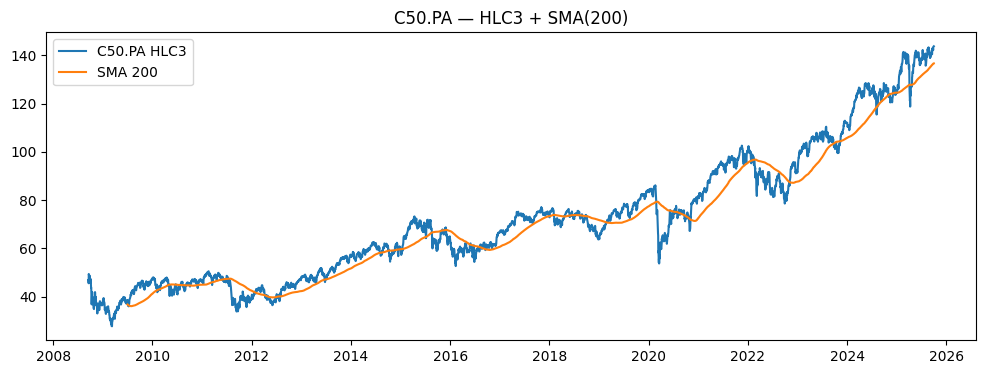

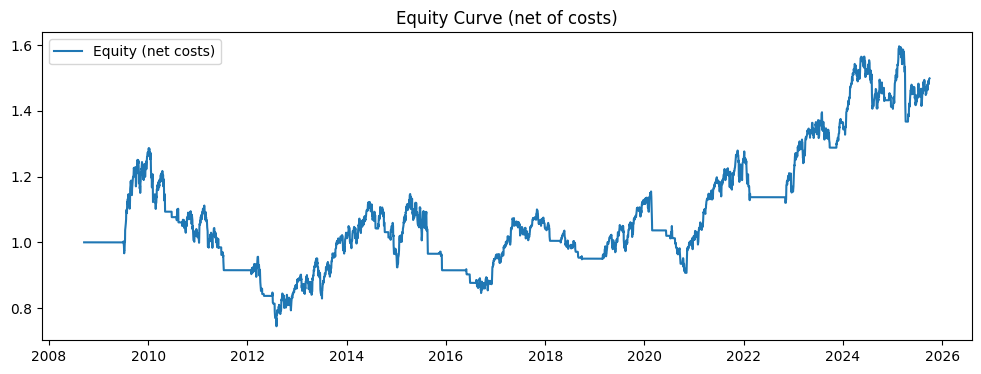

In [10]:
# ---------- 6) Graphiques ----------
plt.figure(figsize=(12,4))
plt.plot(df.index, df["hlc3"], label=f"{TICKER} HLC3")
plt.plot(df.index, df["sma"],  label=f"SMA {N_SMA}")
plt.title(f"{TICKER} — HLC3 + SMA({N_SMA})")
plt.legend(); plt.show()

plt.figure(figsize=(12,4))
plt.plot(equity.index, equity.values, label="Equity (net costs)")
plt.title("Equity Curve (net of costs)")
plt.legend(); plt.show()

In [11]:
# ---------- 7) Recommandation EOD ----------
last, prev = df.iloc[-1], df.iloc[-2]
sig_prev = float(sig_bin.iloc[-1])        # binaire hier->aujourd'hui
w_now    = float(w.iloc[-1])              # poids (après vol targeting)
print("\n=== Recommandation pour la PROCHAINE séance ===")
print(f"Signal binaire: {int(sig_prev)}  |  Poids suggéré (après vol target): {w_now:.2f}")
print("Interprétation: 0 = cash ; 1 = 100% exposé ; valeur entre 0 et 1 = poids proportionnel.")


=== Recommandation pour la PROCHAINE séance ===
Signal binaire: 1  |  Poids suggéré (après vol target): 1.00
Interprétation: 0 = cash ; 1 = 100% exposé ; valeur entre 0 et 1 = poids proportionnel.
